In [246]:
import json
import glob,os
import re
file_directories = glob.glob('/Users/LeoHe/Downloads/tweet_data/*.txt')
file_names = [os.path.basename(x) for x in file_directories]
for i in range(0, len(file_names)):
    print file_names[i] + ' : file_directories[' + str(i) + ']'

tweets_#nfl.txt : file_directories[0]
tweets_#superbowl.txt : file_directories[1]
tweets_#sb49.txt : file_directories[2]
tweets_#patriots.txt : file_directories[3]
tweets_#gohawks.txt : file_directories[4]
tweets_#gopatriots.txt : file_directories[5]


In [247]:
def get_content(line):
    location =  line['tweet']['user']['location']
    content = line['tweet']['text']
    #print content
    if (re.match('.*WA.*', location) or re.match('.*Wash.*', location)):
        return 0, content
    if (re.match('.*MA.*', location) or re.match('.*Mass.*', location)):
        return 1, content
    return -1, -1

In [248]:
#i = 0
train = []
label = []
for line in open(file_directories[1], 'r'):
    info = json.loads(line)
    location, content = get_content(info)
    if location != -1:
        train.append(content)
        label.append(location)
    #i += 1
    #if i == 100000:
    #    break


In [249]:
from sklearn.feature_extraction import text
import re
import nltk 
import string
import numpy as np
from nltk.stem.snowball import SnowballStemmer
from nltk.tag import pos_tag

stop_words = text.ENGLISH_STOP_WORDS
stemmer = SnowballStemmer("english")

def tokenizer_fun(text):
    new_text = re.sub(r'[^A-Za-z]', " ", text)
    new_text = re.sub("[,.-:/()?{}*$#&]"," ",new_text)  # remove all symbols
    new_text = "".join([ch for ch in new_text if ch not in string.punctuation])  # remove all punctuation
    new_text = "".join(ch for ch in new_text if ord(ch) < 128)  # remove all non-ascii characters
    new_text = new_text.lower() # convert to lowercase
    tokens =[word for sent in nltk.sent_tokenize(new_text) for word in nltk.word_tokenize(sent)]
    new_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]{2,}', token):
            new_tokens.append(token)     
    stem = [stemmer.stem(t) for t in new_tokens]
    tagged_sent = pos_tag(stem)
    new_stem = [word for word,pos in tagged_sent if pos == 'NN'] # remove all non-noun words
    return new_stem

In [250]:
from sklearn.cross_validation import train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2, random_state=0)
n_features = 100
TFxIDF = TfidfVectorizer(analyzer='word',tokenizer=tokenizer_fun, stop_words=stop_words,token_pattern='[a-zA-Z]{2,}', norm = 'l2', max_df=0.95, min_df=2, max_features=n_features)
TFxIDF_train = TFxIDF.fit_transform(X_train)
TFxIDF_test  = TFxIDF.transform(X_test)

In [251]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components = 50, algorithm='arpack')
train_lsi = svd.fit_transform(TFxIDF_train)
test_lsi = svd.transform(TFxIDF_test)

In [252]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.decomposition import TruncatedSVD
from sklearn import svm
from sklearn.cross_validation import KFold
kf = KFold(len(X_train), n_folds=5,shuffle=True,random_state=42)
train_lsi_array = np.array(train_lsi)
y_train_array = np.array(y_train)
c = [-3, -2, -1, 0, 1, 2, 3]
scores = [0] * len(c)
for train_index, test_index in kf:
    X_train_kf, X_test_kf = train_lsi[train_index], train_lsi[test_index]
    Y_train_kf, Y_test_kf = y_train_array[train_index], y_train_array[test_index]
    for i, para in enumerate(c):
        LinSvm = svm.LinearSVC(C=10**para)
        LinSvm.fit(X_train_kf, Y_train_kf)
        scores[i] += LinSvm.score(X_test_kf, Y_test_kf)

score = map(lambda x: (x / 5), scores)
print 'score: ' + str(score) 
print 'The best gamma for highest score is ' + str(10**0)

score: [0.69961421713168215, 0.70782915106703348, 0.70858927385609949, 0.70908627721818107, 0.70914474820195528, 0.70896936516124964, 0.62351611184536926]
The best gamma for highest score is 1


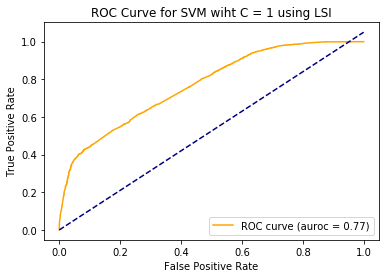

In [253]:
LinSvm_1 = svm.LinearSVC(C=10**0)
LinSvm_1.fit(train_lsi, y_train)
prediction = LinSvm_1.predict(test_lsi)
prediction_stat = LinSvm_1.decision_function(test_lsi)

fpr, tpr, thresholds = roc_curve(y_test, prediction_stat)
auroc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='orange', label='ROC curve (auroc = %0.2f)' % auroc)
plt.plot([0.0, 1.0], [0.0, 1.05], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM wiht C = 1 using LSI')
plt.legend(loc="lower right")
plt.show()

The Confusion Matrix for SVM with c = 1 using LSI: 
Confusion matrix, without normalization
[[4622  294]
 [2216 1420]]
Normalized confusion matrix
[[ 0.94019528  0.05980472]
 [ 0.60946095  0.39053905]]


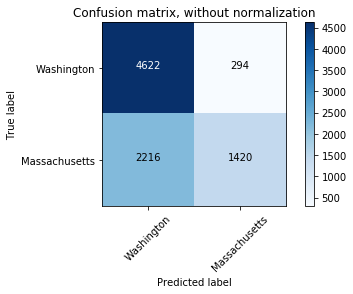

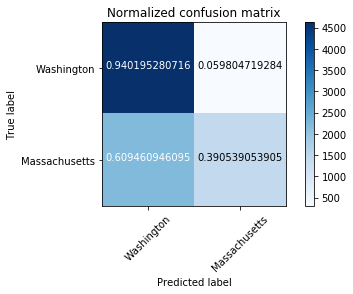

Accuracy = 0.706501, Precision = 0.828471, Recall＝ 0.390539


In [254]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import itertools
# TODO: W,M map to what ?
class_names = ['Washington', 'Massachusetts']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
conf_mat = confusion_matrix(y_test, prediction)
accuracy = accuracy_score(y_test, prediction)
precision = precision_score(y_test, prediction)
recall = recall_score(y_test, prediction)  
    
plt.figure()
print("The Confusion Matrix for SVM with c = 1 using LSI: ")
plot_confusion_matrix(conf_mat, class_names, title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(conf_mat, classes=class_names, normalize=True,title='Normalized confusion matrix')
plt.show()
print("Accuracy = %f, Precision = %f, Recall＝ %f" %(accuracy, precision, recall))
plt.show()

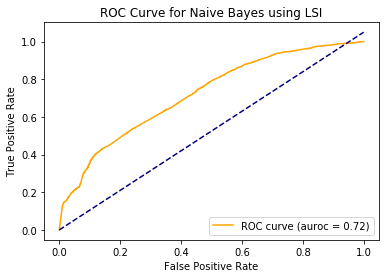

In [255]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
naive_bayes = GaussianNB()
naive_bayes.fit(train_lsi, y_train)

prediction_bayes = naive_bayes.predict(test_lsi)
prediction_bayes_stat = naive_bayes.predict_proba(test_lsi)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, prediction_bayes_stat)
auroc = auc(fpr, tpr)


plt.plot(fpr, tpr, color='orange', label='ROC curve (auroc = %0.2f)' % auroc)
plt.plot([0.0, 1.0], [0.0, 1.05], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Naive Bayes using LSI')
plt.legend(loc="lower right")
plt.show()

The Confusion Matrix for Naive Bayes with c = 0 using LSI: 
Confusion matrix, without normalization
[[3715 1201]
 [1673 1963]]
Normalized confusion matrix
[[ 0.75569569  0.24430431]
 [ 0.46012101  0.53987899]]


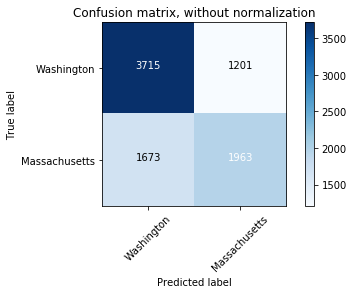

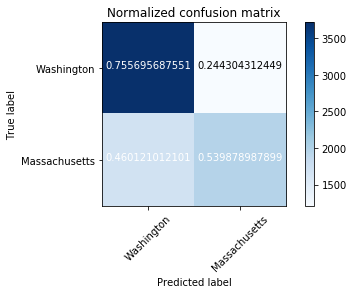

Accuracy = 0.663938, Precision = 0.620417, Recall＝ 0.539879


In [256]:
conf_mat = confusion_matrix(y_test, prediction_bayes)
accuracy = accuracy_score(y_test, prediction_bayes)
precision = precision_score(y_test, prediction_bayes)
recall = recall_score(y_test, prediction_bayes)  
    
plt.figure()
print("The Confusion Matrix for Naive Bayes with c = 0 using LSI: ")
plot_confusion_matrix(conf_mat, class_names, title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(conf_mat, classes=class_names, normalize=True,title='Normalized confusion matrix')
plt.show()
print("Accuracy = %f, Precision = %f, Recall＝ %f" %(accuracy, precision, recall))
plt.show()

In [257]:
from sklearn.linear_model import LogisticRegression


prediction_logistic = logistic.fit(train_lsi, y_train)
val_list = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.05, 0.1, 0.5, 1, 10, 1e2, 1e3]
scores = [0] * len(val_list)
for train_index, test_index in kf:
    X_train_kf, X_test_kf = train_lsi[train_index], train_lsi[test_index]
    Y_train_kf, Y_test_kf = y_train_array[train_index], y_train_array[test_index]
    for i, para in enumerate(val_list):
        logistic = LogisticRegression(penalty="l1", C = para)
        logistic.fit(X_train_kf, Y_train_kf)
        scores[i] += logistic.score(X_test_kf, Y_test_kf)

score = map(lambda x: (x / 5), scores)
print 'score: ' + str(score) 
print 'The best gamma for highest score is ' + str(10)



score: [0.58875678271316723, 0.58875678271316723, 0.58875678271316723, 0.59010161533997629, 0.68169330499117187, 0.70657207191828442, 0.708910877085694, 0.71028491956671824, 0.71040186580721221, 0.7103726388612156, 0.71034340336932844, 0.71034340336932844]
The best gamma for highest score is 10


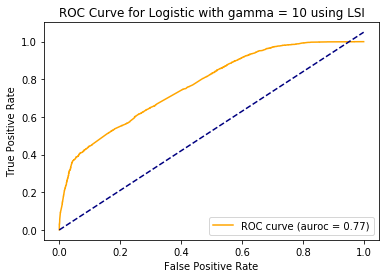

In [258]:
logistic_10 = LogisticRegression(penalty="l1", C = 10)
logistic_10.fit(train_lsi, y_train)
prediction_logistic = logistic_10.predict(test_lsi)
prediction_logistic_stat = logistic_10.predict_proba(test_lsi)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, prediction_logistic_stat)
auroc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='orange', label='ROC curve (auroc = %0.2f)' % auroc)
plt.plot([0.0, 1.0], [0.0, 1.05], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic with gamma = 10 using LSI')
plt.legend(loc="lower right")
plt.show()

The Confusion Matrix for Logistic with gamma = 10 using LSI: 
Confusion matrix, without normalization
[[4633  283]
 [2223 1413]]
Normalized confusion matrix
[[ 0.94243287  0.05756713]
 [ 0.61138614  0.38861386]]


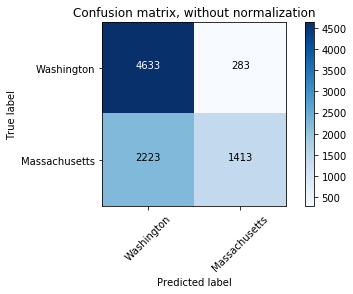

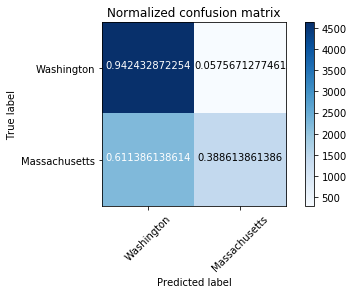

Accuracy = 0.706969, Precision = 0.833137, Recall＝ 0.388614


In [259]:
conf_mat = confusion_matrix(y_test, prediction_logistic)
accuracy = accuracy_score(y_test, prediction_logistic)
precision = precision_score(y_test, prediction_logistic)
recall = recall_score(y_test, prediction_logistic)  
    
plt.figure()
print("The Confusion Matrix for Logistic with gamma = 10 using LSI: ")
plot_confusion_matrix(conf_mat, class_names, title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(conf_mat, classes=class_names, normalize=True,title='Normalized confusion matrix')
plt.show()
print("Accuracy = %f, Precision = %f, Recall＝ %f" %(accuracy, precision, recall))
plt.show()